In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
os.chdir("/Users/trinhha/Documents/VU AMSTERDAM/STUDY/Thesis/Code/")
from src.evaluation import compute_fidelity

plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'stix'  # or other, 'dejavuserif'
plt.rcParams['font.family'] = 'serif'  # or 'DejaVu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 'DejaVu Serif' serif' 'Times'

In [2]:
# Define labels for the metrics to be plotted
metric_labels = {
            "precision": "Precision",
            "recall": "Recall",
            "f1_score": "F1-Score",
            "auc": "AUC"
        }
metric_used = "F1-Score"

## 0. Baseline model

In [3]:
# Get the best baseline model
baseline_model = pd.read_csv("experiments/perf_summary/baseline_val_results.csv").query(f'tuned_by == "{metric_used}"')["version"].astype(str).tolist()
baseline_test_perf = pd.read_csv("results/metrics/baseline.csv")
baseline_test_perf["version"] = baseline_test_perf["version"].astype(str)
baseline_best = baseline_test_perf[baseline_test_perf["version"].isin(baseline_model)]
baseline_best

,accuracy,precision,recall,f1_score,auc,version,timestamp
29,0.834599,0.581845,0.669807,0.622735,0.870187,202505112013,2025-05-13 03:10:57


## 1. Performance trade-off

In [4]:
# Read the test performance of the DP-SGD models
dpsgd_models = pd.read_csv("experiments/perf_summary/dpsgd_val_results.csv").query(f'tuned_by == "{metric_used}"')["version"].astype(str).tolist()
dpsgd_test_perf = pd.read_csv("results/metrics/dpsgd.csv")
dpsgd_test_perf["version"] = dpsgd_test_perf["version"].astype(str)
dpsgd_best = dpsgd_test_perf[dpsgd_test_perf["version"].isin(dpsgd_models)].sort_values(by="eps", ascending=True)
dpsgd_best

,accuracy,precision,recall,f1_score,auc,version,eps,delta,timestamp
84,0.755259,0.414820,0.489079,0.448899,0.710651,202505170232,1.0,0.00001,2025-05-17 05:26:03
85,0.777167,0.460190,0.539615,0.496747,0.744368,202505170526,3.0,0.00001,2025-05-17 07:32:36
86,0.816182,0.556994,0.479229,0.515193,0.757160,202505170732,5.0,0.00001,2025-05-17 09:10:19


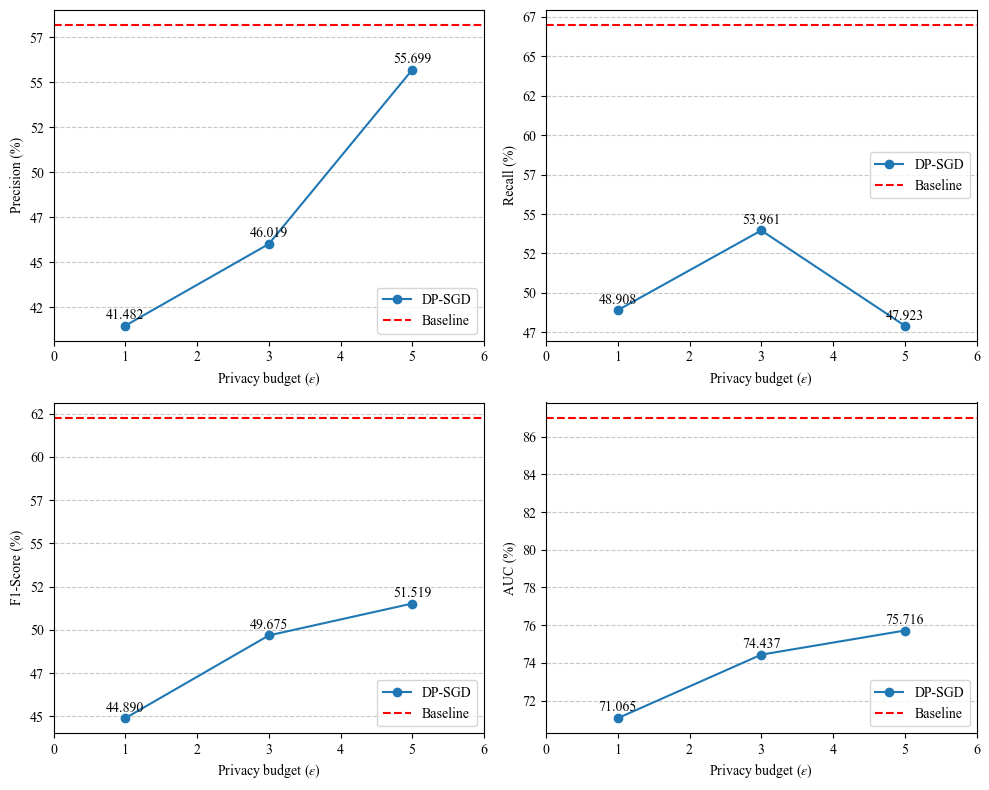

In [5]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, metric in enumerate(metric_labels.keys()):
    ax = axes[i]
    ax.plot(dpsgd_best['eps'], dpsgd_best[metric], marker='o', label='DP-SGD')
    # Add baseline data label
    ax.axhline(y=baseline_best[metric].tolist()[0], color='red', linestyle='--', label='Baseline')
    # Set x axis from 0 to 6
    ax.set_xlim(0, 6)
    # Add data labels
    for j, v in enumerate(dpsgd_best[metric]):
        ax.text(dpsgd_best['eps'].iloc[j], v + 0.002, f"{v * 100:.3f}", ha='center', va='bottom')
    ax.legend(loc='best')
    # Add horizontal grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    # Set y ticks to percentage
    yticks = ax.get_yticks()
    ax.set_yticklabels([f"{int(v * 100)}" for v in yticks])
    # Set y label
    ax.set_ylabel(metric_labels[metric] + " (%)")
    # Set x label
    ax.set_xlabel(r'Privacy budget ($\varepsilon$)')

plt.tight_layout()
plt.savefig("results/figures/performance_comparison.png", dpi=300)
plt.show()

In [6]:
# Create a summary table
summary_table = pd.concat([baseline_best, dpsgd_best], ignore_index=True).set_index("eps")[["precision", "recall", "f1_score", "auc"]].T
# Rename the index to match the metric labels
summary_table.index = [metric_labels[metric] for metric in summary_table.index]
# Given a set of epsilon values
epsilons = {1, 3, 5}
# Create the list of tuples and set the MultiIndex
column_tuples = [("Baseline", "")] + [("DP-SGD", eps) for eps in sorted(epsilons)]
summary_table.columns = pd.MultiIndex.from_tuples(column_tuples)
display(summary_table)

# Format LaTeX rows
latex_rows = []
for idx, row in summary_table.iterrows():
    formatted = " & ".join(f"{v * 100:.3f}" for v in row)
    latex_rows.append(f"{idx} & {formatted} \\\\")

# Extract top-level and sub-level headers
multi_cols = summary_table.columns
top_header = [""] + [f"\\textbf{{{col[0]}}}" for col in multi_cols]
sub_header = ["\\textbf{Metric}"] + [f"\\textbf{{{col[1]}}}" if col[1] != "" else "" for col in multi_cols]

# Compose the LaTeX table
latex_table = r"""
\begin{table}[!t]
    \centering
    \caption{Summary of validation performance (\%) across baseline and DP-SGD models}
    \label{tab:summary-performance}
    \begin{tabular}{lcccc}
    \toprule
& \textbf{Baseline} & \multicolumn{"""+ str(len(multi_cols) - 1) + r"""}{c}{\textbf{DP-SGD}} \\
\cmidrule(lr){3-"""+ str(1 + len(multi_cols)) + r"""}
""" + " & ".join(sub_header) + r""" \\
    \midrule
""" + "\n".join(latex_rows) + r"""
    \bottomrule
    \end{tabular}
    \vspace{2mm}
    \caption*{\footnotesize This table summarizes the test performance of the baseline and DP-SGD models for various privacy levels ($\varepsilon \in \{1, 3, 5\}$), with all models tuned using F1-score as the objective. Each cell reports the value of the corresponding evaluation metric in percentage points.}
    \end{table}"""

print(latex_table)

Baseline    DP-SGD                    
                            1         3         5
Precision  0.581845  0.414820  0.460190  0.556994
Recall     0.669807  0.489079  0.539615  0.479229
F1-Score   0.622735  0.448899  0.496747  0.515193
AUC        0.870187  0.710651  0.744368  0.757160


\begin{table}[!t]
    \centering
    \caption{Summary of validation performance (\%) across baseline and DP-SGD models}
    \label{tab:summary-performance}
    \begin{tabular}{lcccc}
    \toprule
& \textbf{Baseline} & \multicolumn{3}{c}{\textbf{DP-SGD}} \\
\cmidrule(lr){3-5}
\textbf{Metric} &  & \textbf{1} & \textbf{3} & \textbf{5} \\
    \midrule
Precision & 58.185 & 41.482 & 46.019 & 55.699 \\
Recall & 66.981 & 48.908 & 53.961 & 47.923 \\
F1-Score & 62.274 & 44.890 & 49.675 & 51.519 \\
AUC & 87.019 & 71.065 & 74.437 & 75.716 \\
    \bottomrule
    \end{tabular}
    \vspace{2mm}
    \caption*{\footnotesize This table summarizes the test performance of the baseline and DP-SGD models for various privacy levels ($\varepsilon \in \{1, 3, 5\}$), with all models tuned using F1-score as the objective. Each cell reports the value of the corresponding evaluation metric in percentage points.}
    \end{table}


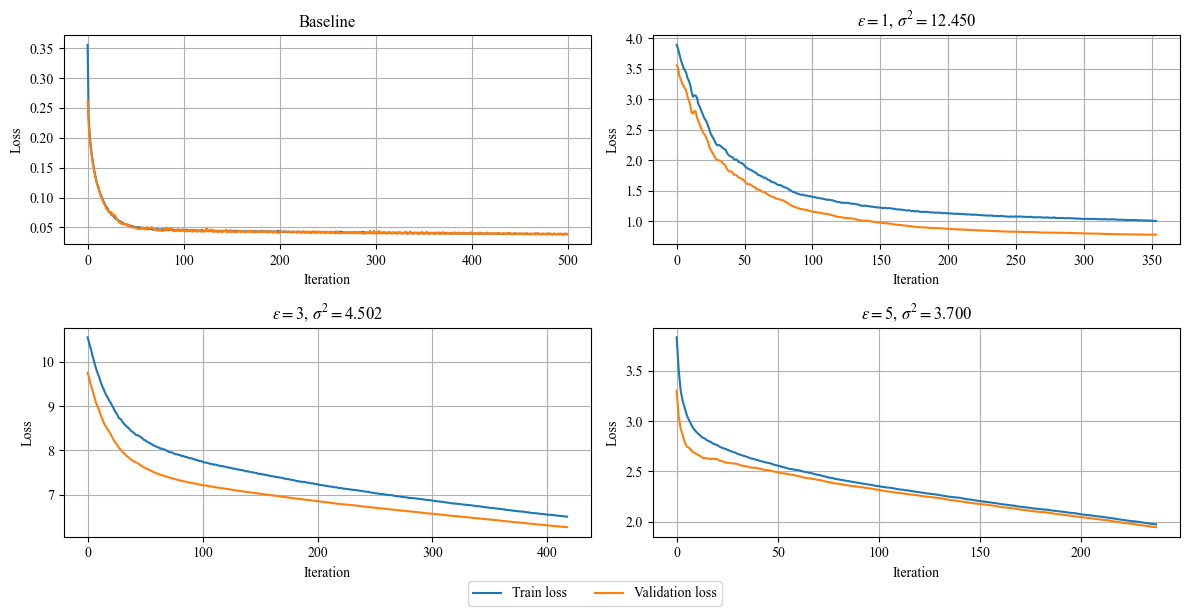

In [7]:
# Layout: 2×2 grid with a subplot for each model
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axes = axes.flatten()

def plot_loss(ax, results_df, epsilon=None, noise=None):
    # Plot loss on the left y-axis
    train = ax.plot(results_df.index, results_df["train_loss"], label='Train loss')
    val = ax.plot(results_df.index, results_df["val_loss"], label='Validation loss')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.tick_params(axis='y')
    if epsilon is not None:
        ax.set_title(r"$\varepsilon =$" + f"{epsilon:.0f}" + r", $\sigma^2 =$" + f"{noise:.3f}")
    else:
        ax.set_title("Baseline")
    ax.grid(True)

    lns = train + val

    return ax, lns

ax = axes[0]
# Plot baseline performance
baseline_version = baseline_best["version"].astype(str).tolist()[0]
results_df = pd.read_csv(f"experiments/tracking/{baseline_version}_baseline.csv")
ax, lns = plot_loss(ax, results_df)

# Iterate through the rows of dpsgd_best DataFrame
for i, row in dpsgd_best.reset_index(drop=True).iterrows():
    # Flatten the axes for easy indexing
    ax = axes[i + 1]
    # Extract the version and epsilon from the row
    version = row["version"]
    epsilon = row["eps"]

    # Read result file
    folder = "experiments/tracking"

    # Read the existing files with the same version prefix
    pattern = os.path.join(folder, f"{version}_noise*.csv")
    for file in glob.glob(pattern):
        results_df = pd.read_csv(file)
        noise = float(file.split("noise")[-1].split(".csv")[0])

    # Plot loss
    ax, lns = plot_loss(ax, results_df, epsilon, noise)

# added these three lines
labs = [l.get_label() for l in lns]
fig.legend(lns, labs, loc='lower center', bbox_to_anchor=(0.5, -0.03),
           ncol=3)

plt.tight_layout()
plt.savefig("results/figures/convergence_comparison.png", dpi=300)
plt.show()

In [8]:
baseline_predictions = pd.read_feather(f"experiments/predictions/baseline/{baseline_version}_pred.feather")

dpsgd_version = '202505080012'
dpsgd_predictions = pd.read_feather(f"experiments/predictions/baseline/{dpsgd_version}_pred.feather")

fidelity = compute_fidelity(baseline_predictions, dpsgd_predictions)

In [12]:
baseline_predictions['anomaly'].mean()

0.2346163917255826

In [16]:
y_test = pd.read_feather("data/processed/y_test.feather")
y_test['y'].mean()

0.2038055337348346